# Chapter 4: Search in Complex Environments


## 4.1: Local Search and Optimization Problems

**Local search** algorithms don't keep track of the path traveled nor states reached. Some characteristics:
- (-) Not systematic (may not find a solution)
- (+) Use little memory
- (+) Can find (reasonable) solutions in large or infinite state spaces where systematic algos can't
- (+) Can solve **optimization problems** (find the best state for an **objective function**)

**State-space landscape**

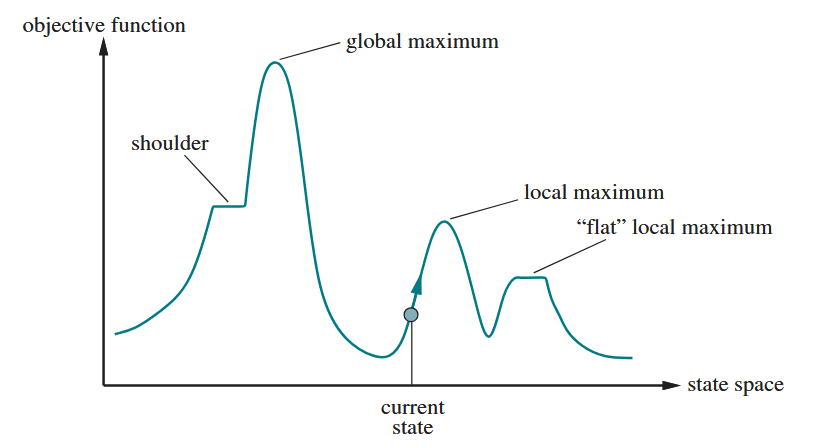

The x-axis represents the different states you can be in. The y-axis represents the value of the objective function. In the **hill-climbing** process, we start at a point and climb upward to attempt to find a **global maximum**. 

In some cases the y-axis represents a cost, in which case we'd actually want to go the opposite direction to find the **global minimum**. When we want to find the minimum, we call the search algorithm **gradient descent**. 

You can think of the cost function ($J$) as the negation of the value function ($f$):

$$
f(x) = -J(x)
$$

Let's make this plot with code!

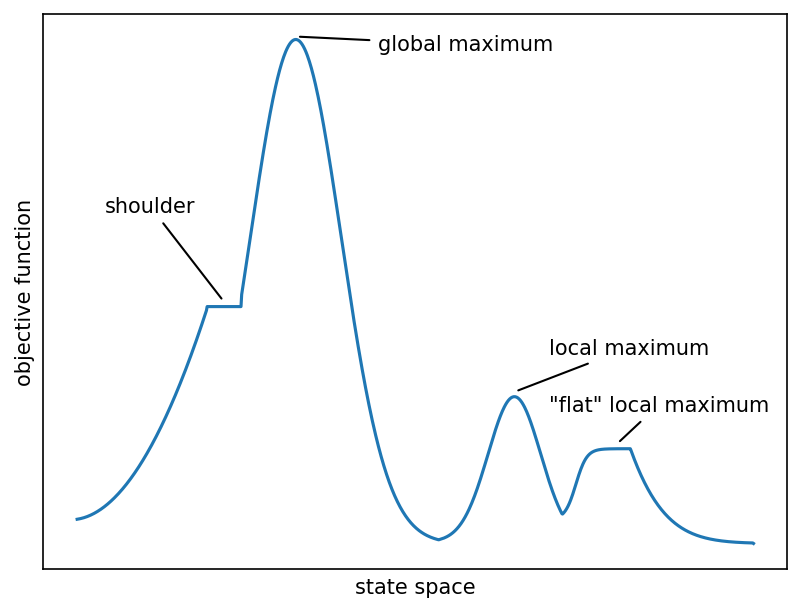

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math


# Utility: probability mass function of normal distribution
def normal_pmf(x, mean, std_dev):
    return (1 / (math.sqrt(2 * math.pi * std_dev**2))) * (
        math.e ** -(((x - mean) ** 2) / 2 * (std_dev**2))
    )


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Set up plot
figure = plt.figure()
figure.set_dpi(150)
axes = figure.add_subplot()
axes.set_ylabel("objective function")
axes.set_xlabel("state space")

axes.set_xticks([])
axes.set_yticks([])

x = np.linspace(1, 100, 1000)
condlist = [
    (x >= 0) & (x < 20),
    (x >= 20) & (x < 25),
    (x >= 25) & (x < 54),
    (x >= 54) & (x < 72),
    (x >= 72) & (x < 82),
    (x >= 82) & (x < 100),
]

funclist = [
    lambda x: ((x * 0.8) ** 2) / 11.5 + 2.5,
    lambda _: 25,
    lambda x: normal_pmf(x, 33, 0.15) * 20,
    lambda x: normal_pmf(x, 65, 0.26) * 10 + 0.15,
    lambda x: sigmoid((x - 74) * 1.25) * 7.5 + 2.5,
    lambda x: normal_pmf(x, 61.6, 0.1) * 20,
]

y = np.piecewise(x, condlist, funclist)

axes.plot(x, y)

# Annotations
arrow_props = {"arrowstyle": "-"}
axes.annotate("shoulder", xy=(22.5, 25.5), xytext=(5, 35), arrowprops=arrow_props)
axes.annotate("global maximum", xy=(33, 53.5), xytext=(45, 52), arrowprops=arrow_props)
axes.annotate("local maximum", xy=(65, 16), xytext=(70, 20), arrowprops=arrow_props)
axes.annotate(
    '"flat" local maximum', xy=(80, 10.5), xytext=(70, 14), arrowprops=arrow_props
)


plt.show()

### 4.1.1: Hill-climbing search

Hill-climbing keeps track of one current state and each iteration moves to the neighboring state with the highest value. It heads in the direction of **steepest descent**.

The book uses the **8-queens problem** as an example to showcase the hill-climbing algorithm:
- Place 8 queens on a chess board so that no queen attacks another
- A heuristic cost function h is the number of pairs of queens that are currently attacking each other. This is 0 for a solution

Let's code up an environment to test 8-queens. Here's the image from the textbook we're trying to simulate (Figure 4.3):
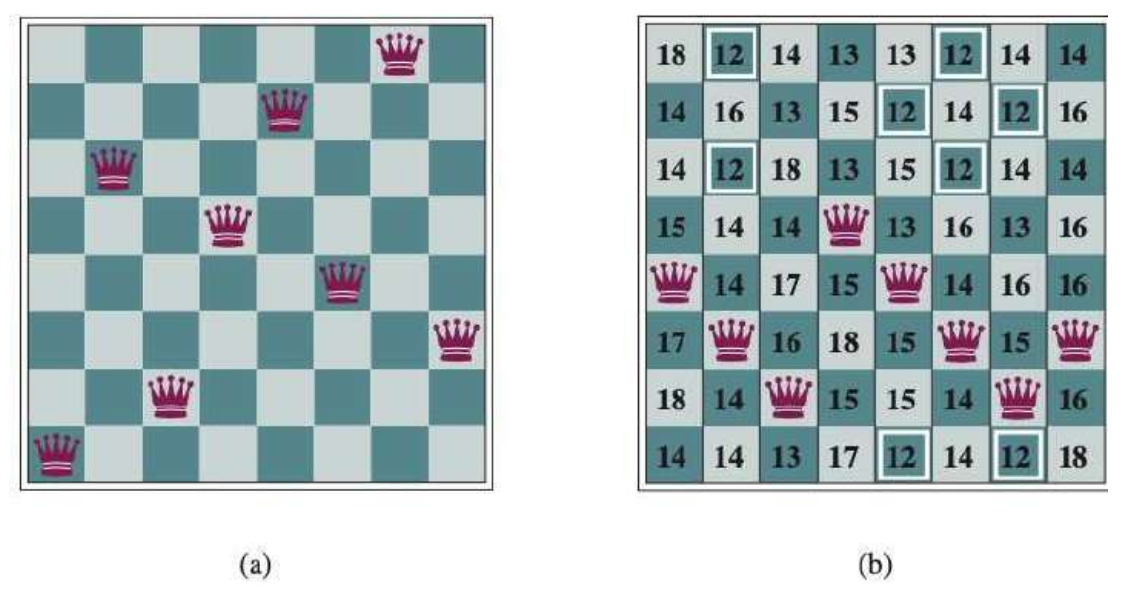

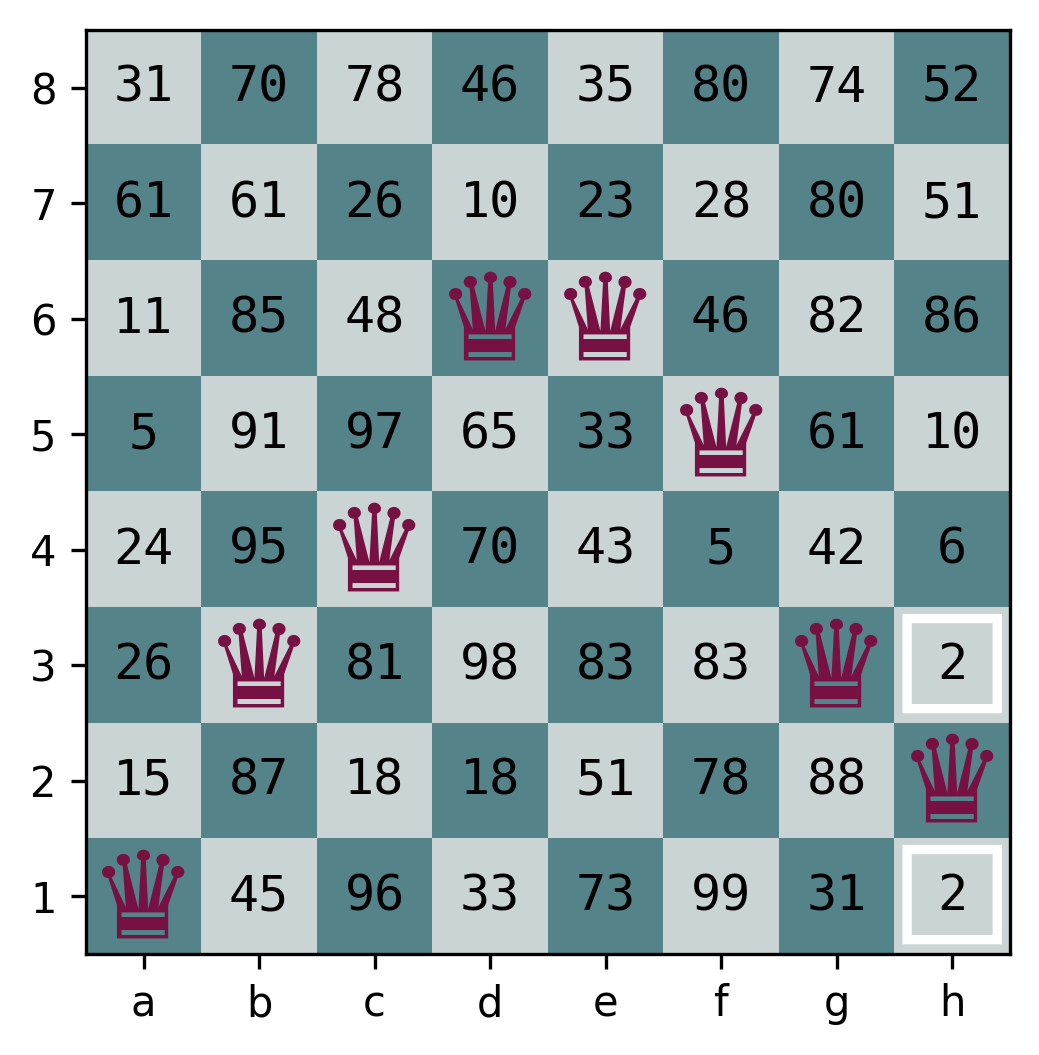

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from typing import Any


# First write a function that renders a chess board with queens and
# optionally numbers representing the total cost if a queen is moved within its column
def plot_board(queen_rows: np.ndarray, costs=None):
    """Shows a plot of the chess board, with queens and optionally costs per cell

    Args:
        queen_positions: An array of ints in the range from 0 to 7 indicating which
          row the queen in the ith column is placed. row 0 is at the top.
        costs: optional 2d array (8x8) of costs corresponding to each cell representing
          the total cost if the queen in the jth column was moved to ith row.
    """
    figure = plt.figure(figsize=(4, 4))
    figure.set_dpi(300)
    axes = figure.add_subplot()
    axes.set_xticks(range(8), ["a", "b", "c", "d", "e", "f", "g", "h"])
    axes.set_yticks(np.arange(7, -1, -1), np.arange(1, 9))

    # Generates xy data in alternating 0 and 1 based on indices into the 2d array
    board_colors = np.indices((8, 8)).sum(axis=0) % 2

    # Colors
    color_map = ListedColormap(["#CAD4D5", "#548389"])

    axes.imshow(board_colors, cmap=color_map)

    # find the lowest cost to highlight it in the cells it appears
    lowest_cost = 0
    if costs is not None:
        lowest_cost = np.min(costs)

    # Place the queens and costs
    for row in range(8):
        for col in range(8):
            is_queen = queen_rows[col] == row
            if is_queen:
                value = "♛"
                font_size = 36
                color = "#771144"
            elif costs is not None:
                value = str(costs[row][col])
                font_size = 12
                color = "black"
            else:
                continue

            plt.text(
                col,
                row,
                value,
                horizontalalignment="center",
                verticalalignment="center",
                color=color,
                fontsize=font_size,
                fontfamily="monospace",
            )

            if costs is not None and costs[row][col] == lowest_cost:
                plt.text(
                    col,
                    row - 0.05,
                    "□",
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="white" if lowest_cost > 0 else "green",
                    fontsize=40,
                    fontfamily="monospace",
                )

    plt.show()


rng = np.random.default_rng()
costs = rng.integers(1, 100, size=(8, 8))
plot_board(rng.choice(range(8), 8, replace=True), costs)

Now that we have a way to visualize a state and neighboring state costs, lets define the actual cost function. It should be the number of pairs of queens attacking each other. 

In this version of the problem, we only allow one queen per column to simplify the state space and the calculations. Therefore, to represent the state we use a one-dimensional array that contains the index of which row a queen is at in the ith column.

In [3]:
def cost(queen_rows: np.ndarray):
    total_cost = 0
    positions = list(enumerate(queen_rows))
    for a in positions:
        for b in positions[a[0] + 1 :]:
            if is_attacking(a, b):
                total_cost += 1
    return total_cost


def is_attacking(a: tuple[int, int], b: tuple[int, int]):
    # row
    if a[0] == b[0]:
        return True
    # column
    if a[1] == b[1]:
        return True
    # diagonal
    if abs(b[0] - a[0]) == abs(b[1] - a[1]):
        return True
    return False

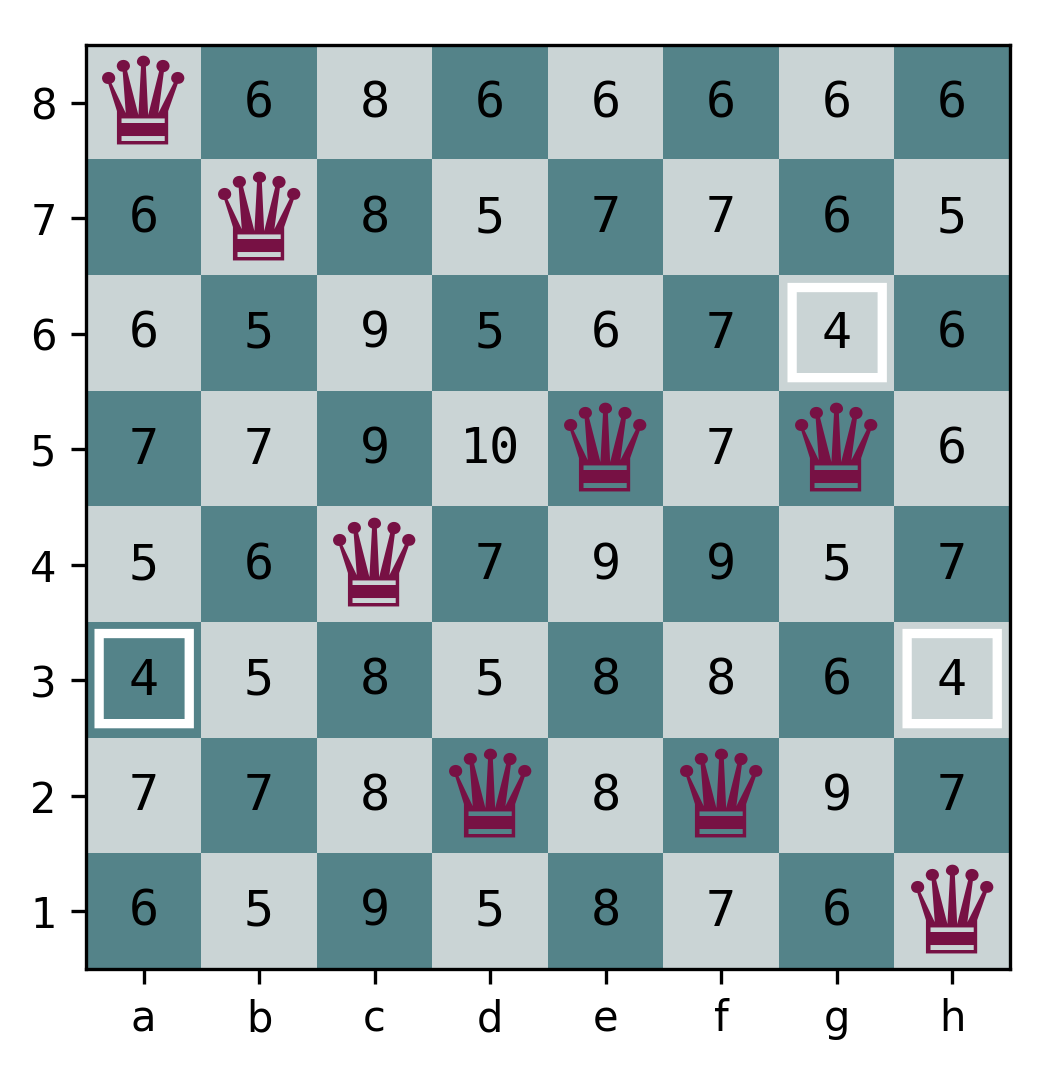

In [33]:
# fill positions randomly
queen_rows = rng.choice(range(8), 8, replace=True)
current_cost = cost(queen_rows)

# calculate neighboring state costs
costs = np.full((8, 8), -1)
for row in range(8):
    for col in range(8):
        # Use current cost if this is the same state as has already been calculated
        if queen_rows[col] == row:
            costs[row][col] = current_cost
            continue
        new_rows = queen_rows.copy()
        new_rows[col] = row
        costs[row][col] = cost(new_rows)

plot_board(queen_rows, costs)

Now let's define the search algorithms themselves. We have hill climbing and gradient descent, which are the same thing in opposite directions:

In [ ]:
from collections.abc import Callable

# Type definition for a state in our problem. In our case (8-queens) this is an ndarray
# vector with 8 elements, each representing the row index of the queen in the ith column.
type State = np.ndarray

MAX_ITERATIONS = 50


def hill_climbing(
    state: State,
    value_function: Callable[[State], int],
    get_neighbors: Callable[[State], np.ndarray],
) -> State:
    """Local search algorithm that returns a state that is a local maximum

    Args:
        state: The current or initial state
        value_function: function that returns the value of a given state
        get_neighbors: function that returns a list of all the neighboring states

    Returns:
        A state that is a local maximum
    """
    current_state = state
    current_value = value_function(state)
    current_iteration = 0
    while current_iteration < MAX_ITERATIONS:
        neighbors = get_neighbors(current_state)
        highest_value_neighbor = neighbors[0]
        highest_value = value_function(highest_value_neighbor)
        for neighbor in neighbors:
            value = value_function(neighbor)
            if value > highest_value:
                highest_value_neighbor = neighbor
                highest_value = value
        if highest_value <= current_value:
            return current_state
        current_state = highest_value_neighbor
        current_value = highest_value
        current_iteration += 1
    return current_state


# Same as hill climbing, but the cost function is inverse of value function
def gradient_descent(
    state: State,
    cost_function: Callable[[State], int],
    get_neighbors: Callable[[State], np.ndarray],
) -> State:
    value_function: Callable[[State], int] = lambda state: -cost_function(state)
    return hill_climbing(state, value_function, get_neighbors)

Now create the dependencies of these algorithms, execute, and plot the result

[4 6 5 2 6 3 5 2]
5
[[2 1 3 0 2 2 1 2]
 [2 0 2 3 2 1 3 2]
 [3 3 3 1 2 3 2 0]
 [3 3 2 2 2 0 3 2]
 [0 2 2 3 3 2 3 2]
 [1 2 0 3 3 3 1 2]
 [1 2 3 3 0 2 2 2]
 [2 2 2 3 2 2 0 2]]
[4 1 5 0 6 3 7 2]
0


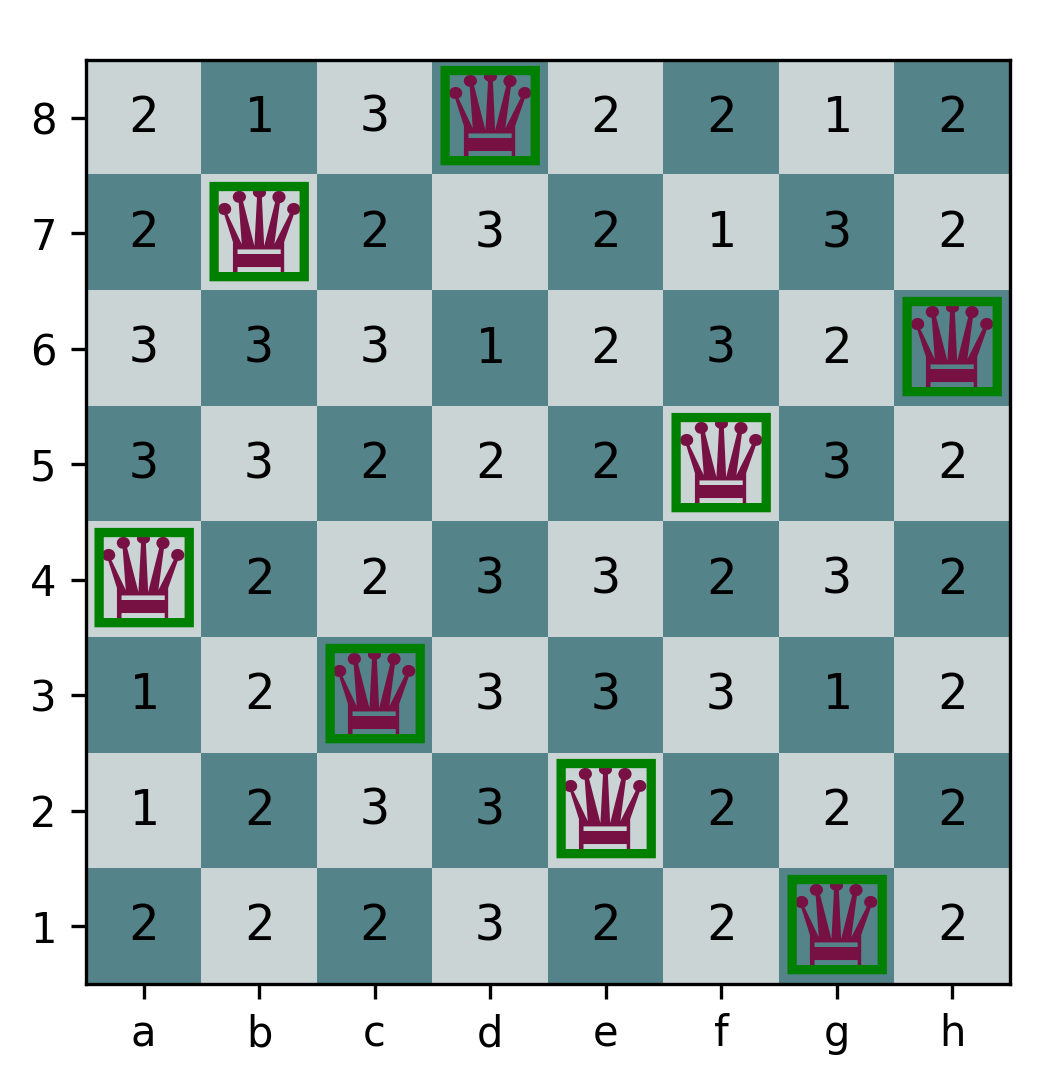

In [ ]:
# Random initial state
initial_state = rng.choice(range(8), 8, replace=True)


def get_neighbors(queen_rows: State) -> np.ndarray:
    neighbors = []
    for i in range(8):
        for j in range(8):
            if j == queen_rows[i]:
                continue
            state = queen_rows.copy()
            state[i] = j
            neighbors.append(state)
    return np.array(neighbors)


print(initial_state)
print(cost(initial_state))

local_maximum_state = gradient_descent(initial_state, cost, get_neighbors)
local_maximum_cost = cost(local_maximum_state)

# calculate neighboring state costs
costs = np.full((8, 8), -1)
for row in range(8):
    for col in range(8):
        new_rows = local_maximum_state.copy()
        new_rows[col] = row
        costs[row][col] = cost(new_rows)

print(costs)
print(local_maximum_state)
print(cost(local_maximum_state))

plot_board(local_maximum_state, costs)

## 4.2: Local Search in Continuous Spaces
Resources:
* [3Blue1Brown -  From Newton’s method to Newton’s fractal (which Newton knew nothing about)](https://www.youtube.com/watch?v=-RdOwhmqP5s)
* [Khan Academy - The Hessian matrix | Multivariable calculus](https://www.youtube.com/watch?v=LbBcuZukCAw)